<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Action-Recognition/blob/main/Human_Action_Recognition_using_Sensor_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = "drive/My Drive/Dataset/all_data.csv"

Mounted at /content/drive


In [ ]:
!pip install minepy
!pip install sklearn_relief
!pip install sklearn-genetic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 496 kB 5.1 MB/s 
  Created wheel for minepy: filename=minepy-1.2.6-cp37-cp37m-linux_x86_64.whl size=177577 sha256=fac1cca3ddbc092261b21210142a392ac6e7d853d46bdd070f73dc0ba8d82614
  Stored in directory: /root/.cache/pip/wheels/81/71/75/403a33428e468a25c93fa7b672d070b304f36642eb699a29e0
Successfully built minepy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 4.6 MB/s 
     |████████████████████████████████| 115 kB 51.1 MB/s 


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from minepy import MINE
from sklearn.feature_selection import mutual_info_regression
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from scipy.special import entr
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import differential_entropy
from scipy.stats import entropy

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from genetic_selection import GeneticSelectionCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import mutual_info_regression

In [64]:
df = pd.read_csv(gdrive_path)
df.tail()

,Unnamed: 0,0_mean_x,0_var_x,0_kurt_x,0_max_x,0_min_x,0_dc_comp_x,0_spec_energy_x,0_spec_entropy_x,0_max_psd_x,...,9_dc_comp_m,9_spec_energy_m,9_spec_entropy_m,9_max_psd_m,9_min_psd_m,9_min_max_psd_m,9_max_xas_m,9_min_xas_m,9_min_max_xas_m,activity
1160,1160,-0.054506,0.001862,-0.040152,0.072510,-0.149658,4178.914871,15331.889818,3.857213,0.420883,...,1.338846e+06,1.511391e+09,6.555544,0.113631,3.274603e-09,2.881788e-08,0.337092,0.000057,0.000170,9
1161,1161,-0.026696,0.002853,5.849030,0.427002,-0.189697,842.076824,1492.626785,5.105730,0.373887,...,1.131603e+06,1.178036e+09,6.289649,0.097086,1.527362e-08,1.573198e-07,0.311587,0.000124,0.000397,9
1162,1162,-0.038772,0.001957,37.360906,0.555176,-0.434082,1766.442641,2957.616036,6.873023,0.149166,...,1.123454e+06,1.164343e+09,6.877409,0.068606,6.772243e-08,9.871164e-07,0.261928,0.000260,0.000994,9
1163,1163,-0.084045,0.001579,-0.482562,0.028564,-0.166016,9406.587377,77108.344139,3.375543,0.413470,...,1.274956e+06,1.408591e+09,6.892931,0.061177,1.379768e-08,2.255369e-07,0.247340,0.000117,0.000475,9
1164,1164,-0.043714,0.001209,0.021406,0.071533,-0.119873,1880.480207,3743.618849,3.326524,0.543291,...,9.423824e+05,8.952466e+08,6.628678,0.059656,1.391945e-07,2.333289e-06,0.244246,0.000373,0.001528,9


In [ ]:
df.drop(df.columns[df.isna().any()].tolist(), axis = 1, inplace = True)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
X = df.drop(['activity'], axis = 1)
y = df['activity']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,test_size=0.1, random_state=21)

In [50]:
#relief f
from sklearn.metrics.pairwise import pairwise_distances
def reliefF(X, y, **kwargs):
    """
    This function implements the reliefF feature selection
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    kwargs: {dictionary}
        parameters of reliefF:
        k: {int}
            choices for the number of neighbors (default k = 5)
    Output
    ------
    score: {numpy array}, shape (n_features,)
        reliefF score for each feature
    Reference
    ---------
    Robnik-Sikonja, Marko et al. "Theoretical and empirical analysis of relieff and rrelieff." Machine Learning 2003.
    Zhao, Zheng et al. "On Similarity Preserving Feature Selection." TKDE 2013.
    """

    if "k" not in kwargs.keys():
        k = 5
    else:
        k = kwargs["k"]
    n_samples, n_features = X.shape

    # calculate pairwise distances between instances
    distance = pairwise_distances(X, metric='manhattan')

    score = np.zeros(n_features)

    # the number of sampled instances is equal to the number of total instances
    for idx in range(n_samples):
        near_hit = []
        near_miss = dict()

        self_fea = X[idx, :]
        c = np.unique(y).tolist()

        stop_dict = dict()
        for label in c:
            stop_dict[label] = 0
        del c[c.index(y[idx])]

        p_dict = dict()
        p_label_idx = float(len(y[y == y[idx]]))/float(n_samples)

        for label in c:
            p_label_c = float(len(y[y == label]))/float(n_samples)
            p_dict[label] = p_label_c/(1-p_label_idx)
            near_miss[label] = []

        distance_sort = []
        distance[idx, idx] = np.max(distance[idx, :])

        for i in range(n_samples):
            distance_sort.append([distance[idx, i], int(i), y[i]])
        distance_sort.sort(key=lambda x: x[0])

        for i in range(n_samples):
            # find k nearest hit points
            if distance_sort[i][2] == y[idx]:
                if len(near_hit) < k:
                    near_hit.append(distance_sort[i][1])
                elif len(near_hit) == k:
                    stop_dict[y[idx]] = 1
            else:
                # find k nearest miss points for each label
                if len(near_miss[distance_sort[i][2]]) < k:
                    near_miss[distance_sort[i][2]].append(distance_sort[i][1])
                else:
                    if len(near_miss[distance_sort[i][2]]) == k:
                        stop_dict[distance_sort[i][2]] = 1
            stop = True
            for (key, value) in stop_dict.items():
                    if value != 1:
                        stop = False
            if stop:
                break

        # update reliefF score
        near_hit_term = np.zeros(n_features)
        for ele in near_hit:
            near_hit_term = np.array(abs(self_fea-X[ele, :]))+np.array(near_hit_term)

        near_miss_term = dict()
        for (label, miss_list) in near_miss.items():
            near_miss_term[label] = np.zeros(n_features)
            for ele in miss_list:
                near_miss_term[label] = np.array(abs(self_fea-X[ele, :]))+np.array(near_miss_term[label])
            score += near_miss_term[label]/(k*p_dict[label])
        score -= near_hit_term/k
    return score


def feature_ranking(score):
    """
    Rank features in descending order according to reliefF score, the higher the reliefF score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]
def selected_features(X, score):
  ranked_features = feature_ranking(score)
  sel_feat = []
  for i in range(X.shape[1]):
    if(ranked_features[i]>0):
      sel_feat.append(ranked_features[i])
    else:
      break
  return X.columns[np.array(sel_feat)]


In [141]:
##symmetrical uncertainty
def SU(df, X,Y):
  if(Y=='activity'):
    IG = mutual_info_classif(np.transpose(np.array([df[X]])), df[Y]).item()
    H_Y = entropy(df[Y])
  else:
    IG = mutual_info_regression(np.transpose(np.array([df[X]])), df[Y]).item()
    H_Y = differential_entropy(df[Y])
  H_X = differential_entropy(df[X])
  su = ((2.0*IG)/(H_X+H_Y))
  #print(IG,H_X,H_Y, su)
  return su
  
#Fast Correlation Based Filter
def FCBF(df, features, C):
  thresh = 0.000001
  N = len(features)
  S_list = {}
  for i in range(N):
    val = SU(df, features[i], C)
    if(val> thresh):
      S_list[features[i]] = val
  S_list = pd.Series(S_list).sort_values(ascending=False)
  no_features = S_list.shape[0]
  a_list = np.ones(no_features)
  for i in range(no_features):
    if(a_list[i]==1):
      Fp = S_list.index[i]
      for j in range(i+1,no_features):
        if(a_list[j]==1):
          Fq = S_list.index[j]
          if(SU(df, Fp,Fq) >= S_list[j]):
            print(f"{j} has been eleminated while in {i}")
            a_list[j]=0
  idx = np.where(a_list==1)[0]
  return S_list.index[idx]

def random_forest_feature_selection(X_train, y_train):
  sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
  sel.fit(X_train, y_train)
  sel.get_support()
  selected_features_rf= X_train.columns[(sel.get_support())].values
  return selected_features_rf

def reliefF_feature_selection(X_train, y_train):
  score = reliefF(X_train.to_numpy(),y_train.to_numpy())
  selected_features_relief = selected_features(X_train,score).values
  return selected_features_relief

def genetic_feature_selection(X_train, y_train):
  estimator = DecisionTreeClassifier()
  model = GeneticSelectionCV(
      estimator, cv=5, verbose=0,
      scoring="accuracy", max_features=100,
      n_population=100, crossover_proba=0.5,
      mutation_proba=0.2, n_generations=50,
      crossover_independent_proba=0.5,
      mutation_independent_proba=0.04,
      tournament_size=3, n_gen_no_change=10,
      caching=True, n_jobs=-1)
  model = model.fit(X_train,y_train)
  selected_features_genetic = X_train.columns[model._get_support_mask()].values
  return selected_features_genetic

def mutual_information_feature_selection(X_train, y_train):
  mi_scores = mutual_info_regression(X_train, y_train, discrete_features=False)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  selected_features_info_gain = mi_scores[mi_scores>0.5].index.values
  return selected_features_info_gain

def chi2_feature_selection(X_train1,y_train):
  scaler = MinMaxScaler()
  X_train1 = scaler.fit_transform(X_train)
  from sklearn.feature_selection import chi2
  chi_scores = chi2(X_train1,y_train)
  p_values = pd.Series(chi_scores[1],index = X.columns)
  p_values.sort_values(ascending = False , inplace = True)
  selected_features_chi = p_values[p_values>0.5].index.values
  return selected_features_chi

In [142]:
def ECFS(df,X_train,y_train):
  selected_feature_list = [random_forest_feature_selection(X_train,y_train),
                           reliefF_feature_selection(X_train,y_train), 
                           genetic_feature_selection(X_train,y_train), 
                           mutual_information_feature_selection(X_train,y_train), 
                           chi2_feature_selection(X_train,y_train)]
  s = set()
  df_train = df.iloc[X_train.index]
  for i in range(5):
    for j in range(len(selected_feature_list[i])):
      s.add(selected_feature_list[i][j])
  final_list = []
  ensemble_list = []
  for feat in s:
    cnt = 0
    for j in range(5):
      if(feat in selected_feature_list[j]):
        cnt+=1
    if(cnt>=4):
      final_list.append(feat)
    else:
      ensemble_list.append(feat)
  sel = FCBF(df_train, ensemble_list, 'activity')
  final_list.extend(sel.values.tolist())
  return final_list

In [144]:
selected_feat = ECFS(df, X_train, y_train)

333 has been eleminated while in 0
337 has been eleminated while in 0
338 has been eleminated while in 0
340 has been eleminated while in 0
343 has been eleminated while in 0
345 has been eleminated while in 0
327 has been eleminated while in 1
334 has been eleminated while in 1
344 has been eleminated while in 1
339 has been eleminated while in 2
342 has been eleminated while in 2
325 has been eleminated while in 5
213 has been eleminated while in 16
297 has been eleminated while in 16
318 has been eleminated while in 18
323 has been eleminated while in 18
245 has been eleminated while in 19
298 has been eleminated while in 19
133 has been eleminated while in 22
237 has been eleminated while in 22
255 has been eleminated while in 22
264 has been eleminated while in 22
290 has been eleminated while in 22
303 has been eleminated while in 22
305 has been eleminated while in 22
306 has been eleminated while in 22
307 has been eleminated while in 22
308 has been eleminated while in 22
311 

In [146]:
len(selected_feat)

230

In [147]:
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]
X_val = X_val[selected_feat]

In [148]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [149]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
y_train =  torch.tensor(y_train.values.astype(np.float32))-1
y_test =  torch.tensor(y_test.values.astype(np.float32))-1
y_val =  torch.tensor(y_val.values.astype(np.float32))-1

In [150]:
class DNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DNN,self).__init__()
        self.hidden1 = nn.Linear(input_size,128)
        self.hidden2 = nn.Linear(128,64)
        self.hidden3 = nn.Linear(64,32)
        self.output = nn.Linear(32,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out

In [151]:
input_size = X_train.shape[1]
output_size = torch.unique(y_train).shape[0]
learning_rate = 0.001
num_epochs = 1001
batch_size = 163
no_of_samples = X_train.shape[0]

In [152]:
criterion = nn.CrossEntropyLoss(reduction='sum')

In [153]:
def extract_batch(X,y,batch_size,step):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]

In [154]:
best_lr = None
best_loss = 100000
best_model = None
best_train_loss = None
best_val_loss = None
for lr in [0.0005,0.001,0.003,0.005,0.01]:
  print(f"Learning rate: {lr}:")
  net = DNN(input_size, output_size)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)  
  train_loss = []
  val_loss = []
  for epoch in range(num_epochs):
    step = 1
    while(batch_size*step<=no_of_samples):
      x,y =  extract_batch(X_train,y_train, batch_size, step)
      # Forward Propagation
      y_predicted = net(x)
      loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
      #loss = cross_entropy(y_predicted,y)
      # Backward propagation and update
      loss.backward()
      optimizer.step()
      # Performing zero grad before new step
      optimizer.zero_grad()
      step = step+1
    train_loss.append(criterion( net(X_train),  torch.tensor(y_train, dtype=torch.long)).item()) 
    val_loss.append(criterion( net(X_val),  torch.tensor(y_val, dtype=torch.long)).item())
      #appending the loss to the loss list
    if(epoch%100==0):
      print(f'epoch: {epoch}, loss = {train_loss[-1]}')
  val_ls = sum(val_loss)/len(val_loss)
  if(val_ls<=best_loss):
    best_loss = val_ls
    best_lr = lr
    best_model = net
    best_val_loss = val_loss
    best_train_loss = train_loss
print(f"Best_lr:{best_lr}\nBest_loss:{best_loss}")


Learning rate: 0.0005:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0, loss = 1930.5953369140625
epoch: 100, loss = 73.6736831665039
epoch: 200, loss = 40.500858306884766
epoch: 300, loss = 25.613262176513672
epoch: 400, loss = 17.949460983276367
epoch: 500, loss = 18.0140380859375
epoch: 600, loss = 19.926040649414062
epoch: 700, loss = 23.79229736328125
epoch: 800, loss = 10.18874740600586
epoch: 900, loss = 14.73678970336914
epoch: 1000, loss = 10.17471694946289
Learning rate: 0.001:
epoch: 0, loss = 1818.8587646484375
epoch: 100, loss = 47.091087341308594
epoch: 200, loss = 23.346324920654297
epoch: 300, loss = 17.62371063232422
epoch: 400, loss = 9.39721393585205
epoch: 500, loss = 12.773235321044922
epoch: 600, loss = 10.903157234191895
epoch: 700, loss = 7.879705429077148
epoch: 800, loss = 13.58222484588623
epoch: 900, loss = 12.343847274780273
epoch: 1000, loss = 5.046199321746826
Learning rate: 0.003:
epoch: 0, loss = 1507.453857421875
epoch: 100, loss = 29.234331130981445
epoch: 200, loss = 13.636115074157715
epoch: 300, loss = 9.1809

In [155]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)   
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum()*1.0 / len(correct_pred)
    acc = acc * 100
    return acc

In [162]:
y_pred = best_model(X_test)
acc = multi_acc(y_pred, y_test)
print(f"Test accuracy is {(acc):.2f}%")

Test accuracy is 97.71%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'No of Epochs')

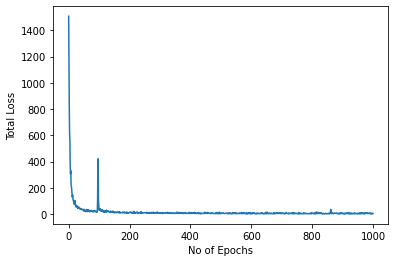

In [157]:
import seaborn as sns
sns.lineplot(range(1001),best_train_loss)
plt.ylabel("Total Loss")
plt.xlabel("No of Epochs")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'No of Epochs')

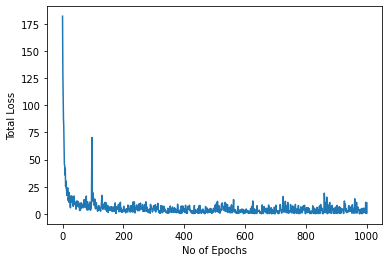

In [158]:
sns.lineplot(range(1001),best_val_loss)
plt.ylabel("Total Loss")
plt.xlabel("No of Epochs")